In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

from PIL import Image
import numpy as np
import random
import pickle
from scipy.stats import wasserstein_distance
from tqdm import tqdm as tqdm
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})
from matplotlib.cm import get_cmap
from collections import Counter
import copy

# Preamble

In [2]:
def count_consecutive_sequences(lst, L):
    if L <= 0:
        raise ValueError("Size L must be a positive integer.")

    if L > len(lst):
        return {}

    # Create all consecutive sequences of size L
    sequences = [tuple(lst[i:i + L]) for i in range(len(lst) - L + 1)]

    # Use Counter to count the occurrences of each sequence
    return dict(Counter(sequences))
    
def most_repeated_ratio(lst):
    if not lst:  # Check for an empty list
        return 0
    freq = Counter(lst)
    max_repeated = max(freq.values())
    ratio = max_repeated / len(lst)
    
    return ratio
    
def originality_rate(list_generated, original, max_l):
    originality = {}
    for L in range(2,max_l+1):
        originality_counts = []
        sequence_counts = []
        
        # Count consecutive sequences for both sequences
        original_counts = count_consecutive_sequences(original, L)
    
        for generated in list_generated:
            generated_counts = count_consecutive_sequences(generated, L)
            
            # Compute ratios for keys in the original dictionary
            for seq,count in generated_counts.items():
                if seq not in original_counts:
                    originality_counts.append(count)  # Avoid division by zero
    
                sequence_counts.append(count)
        originality_ratio = np.sum(originality_counts)/np.sum(sequence_counts)

        originality[L] = originality_ratio
    return originality

def get_probs(sequence,featnum):
    sequence = list(sequence)
    # probability of each feature
    probs = {}
    for feat in range(featnum):
        probs[feat] = sequence.count(feat)/len(sequence)
    return probs

def get_markov_probs(sequence,featnum):
    # probability of each feature given previous feature
    markov_probs = {feat:[] for feat in range(featnum)}
    for f in range(len(sequence)):
        markov_probs[sequence[f]].append(sequence[(f+1)%len(sequence)])
    for feat0 in range(featnum):
        mprob = {}
        for feat1 in markov_probs[feat0]:
            mprob[feat1] = markov_probs[feat0].count(feat1)/len(markov_probs[feat0])
        markov_probs[feat0] = mprob
    return markov_probs


def generate_markov_sequence(probs, markov_probs,length):
    markov_sequence = random.choices(list(probs.keys()), weights=probs.values(), k=1)
    for _ in range(length-1):
        markov_sequence += random.choices(
            list(markov_probs[markov_sequence[-1]].keys()),
            weights=markov_probs[markov_sequence[-1]].values(),
            k=1
        )
    return markov_sequence

def generate_uncorrelated_sequence(probs,length):
    return random.choices(list(probs.keys()), weights=probs.values(), k=length)

def find_broken_rules(sequence,rules,res=None):
    if res == None:
        res = {}
        
    for i,feat in enumerate(sequence):
        has_rule, respect_rule, rule_name = rules(i,sequence)
        if has_rule and respect_rule:
            res[rule_name] = np.array([1,0]) + res.get(rule_name,np.array([0,0]))
        elif has_rule and not respect_rule:
            res[rule_name] = np.array([1,1]) + res.get(rule_name,np.array([0,0]))

    return res

def separation_stats(lst, j):
    if isinstance(lst[0],list) or isinstance(lst[0],np.ndarray):
        average=[]
        std=[]
        for l in lst:
            m,s = separation_stats(l,j)
            average.append(m)
            std.append(s)
        return np.nanmean(average),np.nanstd(std)
    
    indices = [i for i, x in enumerate(lst) if x == j]
    if len(indices) < 2:
        return None,None  # Not enough occurrences to calculate separations
    
    separations = np.diff(indices)
    mean_separation = np.mean(separations)
    std_separation = np.std(separations)
    
    return mean_separation, std_separation

def entropy(probs):
    ent = 0
    for f in probs:
        ent -= probs[f]*np.log(probs[f])/np.log(2)
    return ent

def markov_entropy(markov_probs,probs):
    ent = 0
    for f in probs:
        for ff in markov_probs[f]:
            ent -= probs[f]*markov_probs[f][ff]*np.log(markov_probs[f][ff])/np.log(2)
    return ent


# Roblox analysis

Load some original levels

In [5]:
features = []
featurebytes = []
for j in range(32):
    features.append(Image.open('Data/Roblox/features/'+str(j)+'.png'))
    featurebytes.append(features[-1].tobytes())

pics = {}
sequences = {}
for level in ['1','6']:#The level in the paper is level 6 but we also gathered the data for level 1
    pics[level] = Image.open('Data/Roblox/original_levels/'+level+'.png')
    sequences[level] = []
    size = [int(pics[level].size[j]/8) for j in range(2)]
    for y in range(size[1]):
        for x in range(size[0]):
            feature = pics[level].crop((8*x,8*y,8*(x+1),8*(y+1)))
            sequences[level].append(featurebytes.index(feature.tobytes()))

In [135]:
level = "6"
sequence = sequences[level]
featnum= len(Counter(sequence))
length=len(sequence)

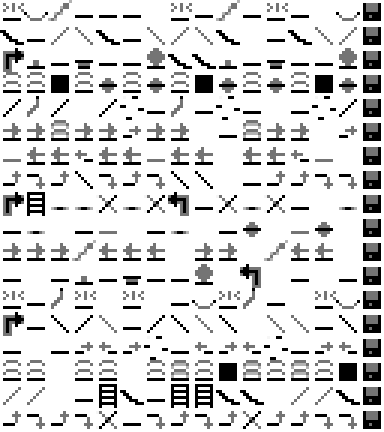

In [136]:
def sequence2pic(sequence,scale=3,filename=None):
    mm = min(16,len(sequence))
    pic = Image.new('RGBA',(8*mm,8*int(np.ceil(len(sequence)/mm))))
    for j,f in enumerate(sequence):
        x = 8*(j%mm)
        y = 8*int(j/mm)
        pic.paste(features[f],(x,y))

    pic = pic.resize((pic.size[0]*scale,pic.size[1]*scale),0)

    if filename:
        pic.save("./Figures/"+filename+".png")
        print(f"Image saved as '{filename}'")
        
    return pic

sequence2pic(sequence,3)

Write down the possible broken transitions

In [137]:
def roblox_rules(i,arr):
    has_rule = True
    respect_rule = False
    feat = arr[i]
    rule_name = None

    ball_seq = np.array([26, 2, 28, 2, 2, 27])
    lseq = len(ball_seq)
    larr = len(arr)
    try:
        if feat == 26 and i+lseq <= larr: 
            respect_rule = (arr[i:i+lseq] == ball_seq).all()
            rule_name = "ball"
        elif feat == 28 and i-2+lseq <= larr and i-2 >= 0: 
            respect_rule = (arr[i-2:i-2+lseq] == ball_seq).all()
            rule_name = "ball"
        elif feat == 27 and i-5+lseq <= larr and i-5 >= 0: 
            respect_rule = (arr[i-5:i-5+lseq] == ball_seq).all()
            rule_name = "ball"
        elif feat == 6:
            respect_rule = (arr[i-1]==5)
            rule_name = "jump"
        else:
            has_rule = False
            
    except IndexError:
        has_rule = False
        
    return has_rule, respect_rule, rule_name


and generate new levels using QRC

In [138]:
q_list = np.array([5,6,7,8])
beta=1
generate_new = False
n_samples = 1000 

In [ ]:
import qrc 

if generate_new:
    buffer = 10
    for q in q_list:
        params = './Parameters/roblox_'+level+'_q'+str(q)+'.yaml'
        model = qrc.SequenceModel(params=params)
        model.learn(sequence, plot=True)
        plt.show()
    
        new_sequences = []
        for s in range(n_samples):
            new_seq = model.generate(length=length+buffer,variation=beta)
            new_sequences.append(new_seq[buffer:])
            
        with open('Data/Roblox/new_sequences_level_'+level+'_q_'+str(q)+'.p', 'wb') as file:
            pickle.dump(new_sequences,file)

We can load them here:

In [139]:
new_sequences = {"QRC":{}}

for q in q_list:
    with open('Data/Roblox/new_sequences_level_'+level+'_q_'+str(q)+'.p', 'rb') as file:
        new_sequences["QRC"][q] = pickle.load(file)

This is how a typical level looks like

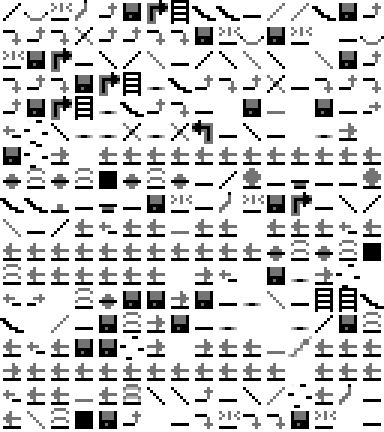

In [141]:
sequence2pic(random.choice(new_sequences["QRC"][6]))

We can also generate samples with Markov

In [142]:
probs = get_probs(sequence,featnum)
markov_probs = get_markov_probs(sequence,featnum)

In [143]:
new_sequences["Markov"] = [generate_markov_sequence(probs, markov_probs,length) for _ in range(n_samples)]
new_sequences["Uncorr"] = [generate_uncorrelated_sequence(probs,length) for _ in range(n_samples)]

And run the analysis on the generated data

In [144]:
def to_rate(dic):
    errors = list(dic.keys())
    errors.sort()
    rate = [dic[e][1]/dic[e][0] for e in errors]
    return [errors,rate]

mistakes = []
originality = []
mean_sep = []
std_sep = []

for j, seqs in enumerate([new_sequences["Uncorr"], new_sequences["Markov"]]+[new_sequences["QRC"][q] for q in q_list]):
    o = originality_rate(seqs,sequence,max_l = 20)
    originality.append(o)
    m,s = separation_stats(seqs,0)
    mean_sep.append(m)
    std_sep.append(s)
    
    brules={}
    for n in range(n_samples):
        find_broken_rules(seqs[n],roblox_rules,brules)
        
    mistakes.append(to_rate(brules))
        

We can look and the separatin metrics:

In [145]:
mean_sep

[15.896811825742347,
 16.040331149157048,
 19.221430033706927,
 15.020826725511354,
 16.867325288348972,
 13.958699921493064]

In [146]:
std_sep

[4.616941815482458,
 4.215967530617123,
 6.186977352353881,
 4.131772106272343,
 3.367808092619073,
 2.9432105643204385]

An the originality for different number of qubits

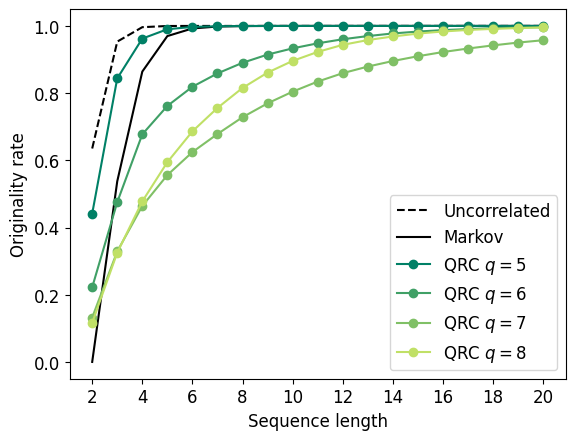

In [147]:
plt.plot(originality[0].keys(),originality[0].values(),'k--',label="Uncorrelated")
plt.plot(originality[1].keys(),originality[1].values(),'k',label="Markov")

cmap = plt.colormaps.get_cmap("summer")
colors = [cmap(i) for i in np.linspace(0, 1, )] 

for i,q in enumerate(q_list):
    color = cmap(i/4)
    plt.plot(originality[i+2].keys(),originality[i+2].values(),'o-',label="QRC $q="+str(q)+"$",color=color)

plt.xticks(range(2,22)[::2])
plt.legend()
plt.ylabel("Originality rate")
plt.xlabel("Sequence length")
plt.savefig("./Figures/originality_roblox.png")
plt.show()

as well as the error rate

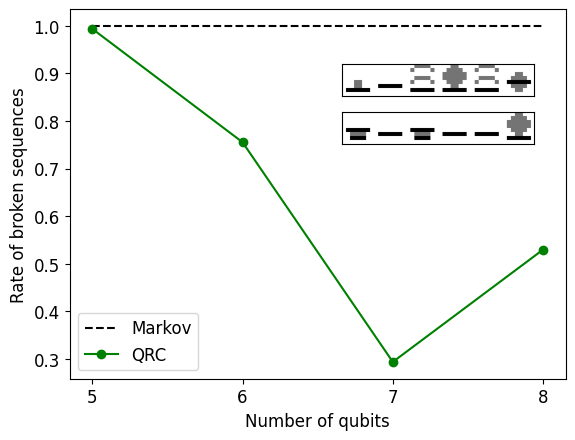

In [148]:
q_list = np.array(q_list)

ball_mistakes = np.array(np.array(mistakes)[:,1,0],dtype=float)
images =  [Image.open("./Figures/ball_error"+str(i)+".png") for i in range(1,3)]
img_width, img_height = images[0].size
scale = 0.4


fig, ax1 = plt.subplots()
ax1.plot(q_list,q_list*0 + ball_mistakes[1],'--',color="k",label="Markov")
ax1.plot(q_list,ball_mistakes[2:],'o-',color="green",label="QRC")

for i,image in enumerate(images):
    inset = fig.add_axes([0.5 , 0.6+ i*0.1, scale,scale* img_height/img_width])
    inset.imshow(image)
    plt.setp(inset, xticks=[], yticks=[])

#ax1.set_yscale("log")
ax1.set_ylabel("Rate of broken sequences")
ax1.set_xlabel("Number of qubits")
ax1.legend()
ax1.set_xticks([5,6,7,8])
plt.savefig("./Figures/roblox_errors.png",dpi=300)

plt.show()

# Mario analysis

First choose a game level. Currently we have 1-1, 1-2, 1-3 and 1-4 from Super Mario Bros.

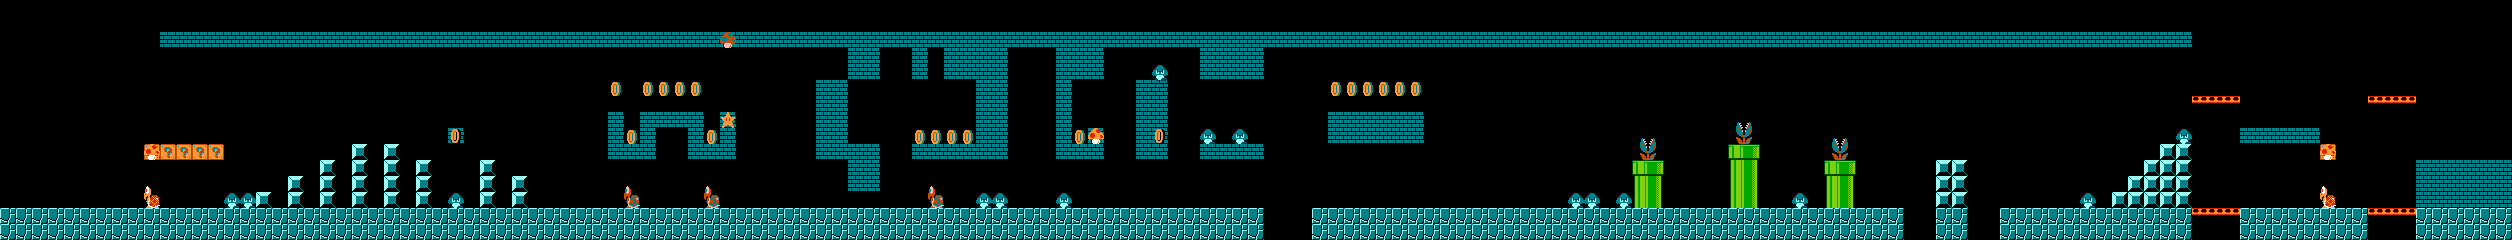

In [7]:
level = '1-2'

pic = Image.open('Data/SMB/original_levels/'+level+'.png')

pic

This level will now be split into columns one block wide. Each unique column will be regarded as a separate feature. The original levels were modified to get them down to 32 features per level.

In [92]:
length, height = [int(pic.size[j]/16) for j in range(2)]

columns = [ None for _ in range(length)]
unique_columns = []
row_counter = {}
for x in range(length):
    columns[x] = pic.crop((16*x,0,16*(x+1),height*16))
    if columns[x] not in unique_columns:
        unique_columns.append(columns[x])
        row_counter[unique_columns.index(columns[x])] = 1
    else:
        row_counter[unique_columns.index(columns[x])] += 1

featnum = len(unique_columns)
print("Number of unique columns:", featnum)

sequence = []
for column in columns:
    sequence.append(unique_columns.index(column))

print('\nSequence of features in level:')
print(sequence)

Number of unique columns: 32

Sequence of features in level:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 4, 5, 6, 5, 7, 5, 8, 5, 8, 5, 7, 5, 9, 5, 7, 5, 6, 5, 5, 5, 5, 5, 10, 11, 10, 12, 12, 10, 11, 13, 5, 5, 5, 5, 5, 14, 14, 15, 15, 5, 5, 16, 11, 16, 16, 17, 17, 5, 5, 5, 17, 16, 18, 5, 5, 14, 19, 5, 5, 20, 21, 20, 21, 22, 22, 22, 5, 23, 23, 23, 23, 23, 23, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 5, 3, 24, 25, 5, 5, 5, 5, 26, 27, 5, 5, 3, 5, 24, 25, 5, 5, 5, 22, 22, 7, 7, 22, 22, 5, 5, 5, 5, 5, 3, 5, 4, 6, 7, 8, 28, 29, 29, 29, 30, 30, 30, 30, 30, 1, 0, 0, 29, 29, 29, 31, 31, 31, 31, 31, 31]



Sequence of all features in order:


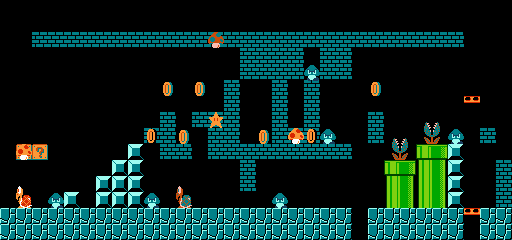

In [93]:
def sequence2pic(sequence,save=False, filename=None):
    pic = Image.new('RGB',(16*len(sequence),columns[0].size[1]))
    for x, c in enumerate(sequence):
        pic.paste(unique_columns[c],(x*16,0))

    if save and filename:
        pic.save("./Figures/"+filename+".png")
        print(f"Image saved as '{filename}'")
    
    return pic

print('\nSequence of all features in order:')
sequence2pic(list(range(featnum)))

Next we will identify some game breaking sequences and write them as a set of rules. Some rules are directly imposed like having the two sides of the pipe connected, others are indirectly imposed like never blocking passage.

In [95]:
def mario_rules(i,arr):
    has_rule = True
    respect_rule = False
    feat = arr[i]
    rule_name = ""

    try:
        if level == "1-2" and i>0 and i<len(arr):
            if feat == 25: #Checks if the right part of the small tub follows the left
                respect_rule = (arr[i-1] == 24)
                rule_name = "2"
            elif feat == 24: #Checks if the left part of the small tub preceeds the right
                respect_rule = (arr[i+1] == 25)
                rule_name = "2"
            elif feat == 27: #Checks if the right part of the large tub follows the left
                respect_rule = (arr[i-1] == 26)
                rule_name = "2"
            elif feat == 26: #Checks if the left part of the large tub preceeds the right
                respect_rule = (arr[i+1] == 27)
                rule_name = "2"
            elif feat == 17: #Checks that the passage is not blocked
                respect_rule = (arr[i+1] != 31) and (arr[i-1] != 31)
                rule_name = "2"
            elif feat == 16: #Checks that the coin is not blocked
                respect_rule = (arr[i-1] != 17) and (arr[i+1] != 17)
                rule_name = "3"
            elif feat == 14: #Checks that the passage is possible
                respect_rule = (arr[i-1] != 17) and ((arr[i+1] != 26) and (arr[i+1] != 28))
                respect_rule2 = (arr[i+1] != 17) and ((arr[i-1] != 26) and (arr[i-1] != 28))
                respect_rule = respect_rule and respect_rule2
                rule_name = "3"
            elif feat == 10: #Checks that the passage is possible
                respect_rule = (arr[i-1] != 17) and (arr[i+1] != 26) and (arr[i+1] != 28)
                respect_rule2 = (arr[i+1] != 17) and (arr[i-1] != 26) and (arr[i-1] != 28)
                respect_rule = respect_rule and respect_rule2
                rule_name = "3"
            else:
                has_rule = False
        else:
            has_rule = False
    except IndexError:
        has_rule = False
        
    return has_rule, respect_rule, rule_name


Now let's initialize and train a model and use it to generate new sequences. We'll create sequences of the same length as the original.

In [97]:
beta_list = [0.01,0.03,0.1,0.3,0.7,1,2,3,10,30]
generate_new = False
n_samples = 1000

In [ ]:
import qrc

if generate_new:
    buffer = 10
    # train
    params = './Parameters/mario_'+level+'.yaml'
    model = qrc.SequenceModel(params=params)
    model.learn(sequence, plot=True)
    plt.show()

    for beta in beta_list:
        print(beta)
        # generate
        new_sequences = []
        for s in range(n_samples):
            new_seq = model.generate(length=length+buffer,variation=beta)
            new_sequences.append(new_seq[buffer:])
            
        with open('Data/SMB/new_sequences_level_'+level+'_beta_'+str(beta)+'.p', 'wb') as file:
            pickle.dump(new_sequences,file)

Here's one of those new levels.

In [98]:
# retrieve previously generated levels
new_sequences={"QRC":{}}

for beta in beta_list:
    with open('Data/SMB/new_sequences_level_'+level+'_beta_'+str(beta)+'.p', 'rb') as file:
        new_sequences["QRC"][beta] = pickle.load(file)

Here is a QRC generated sample

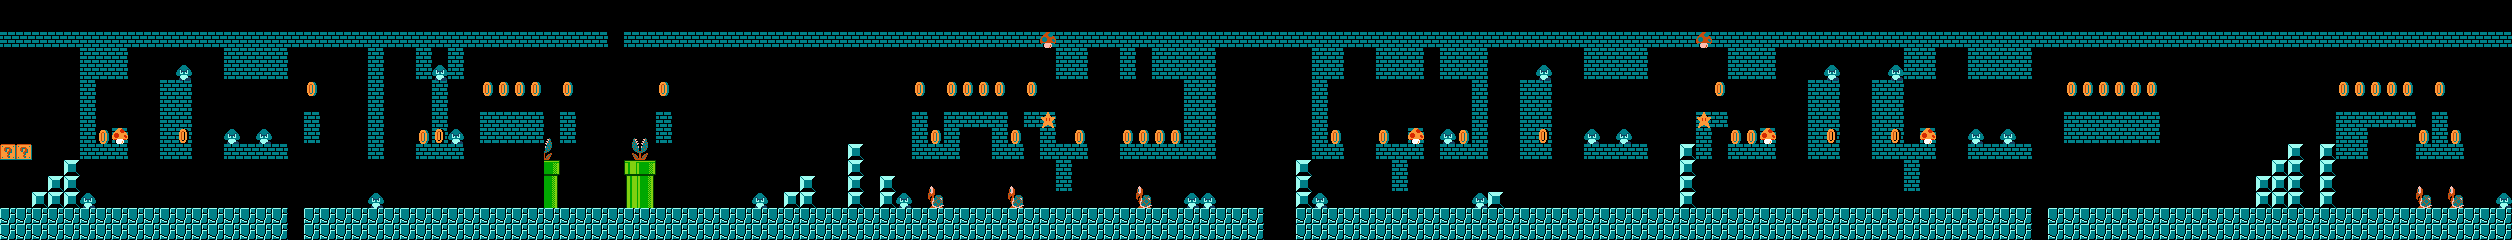

In [99]:
sequence2pic(random.choice(new_sequences["QRC"][2]))

Alternatively we could have generated features randomly according to the frequencies at which they appear in the original, or according to a Markov chain. To test these options, we'll calculate the probabilities and generate the samples

In [109]:
probs = get_probs(sequence)
markov_probs = get_markov_probs(sequence)

new_sequences["Markov"] = [generate_markov_sequence(probs, markov_probs,length) for _ in range(n_samples)]
new_sequences["Uncorr"] = [generate_uncorrelated_sequence(probs,length) for _ in range(n_samples)]

Here's a random sample generated when sampling in an uncorrelated way.

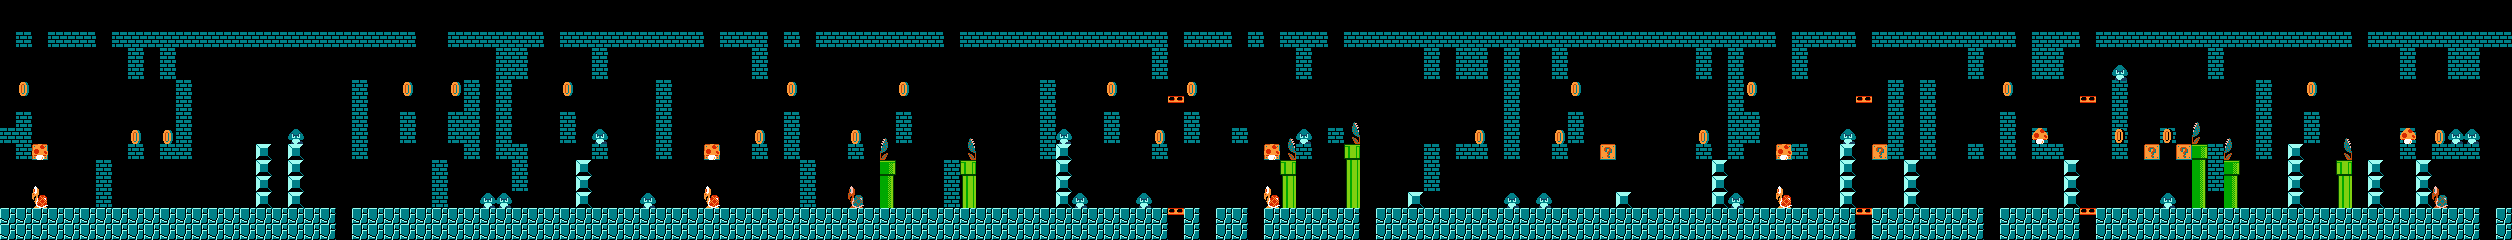

In [110]:
sequence2pic(random.choice(new_sequences["Uncorr"]))

Here's one generated by a Markov chain.

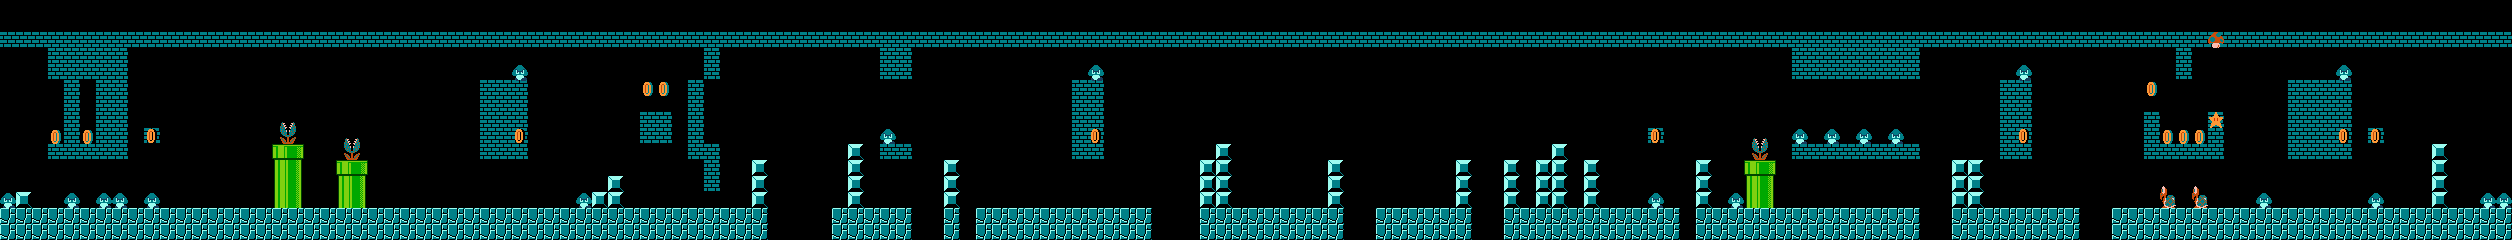

In [116]:
sequence2pic(random.choice(new_sequences["Markov"]))

We run the two analysis methods described in the paper and compare the QRC-generated samples to ones generated by the other methods.

In [118]:
def to_rate(dic):
    errors = list(dic.keys())
    errors.sort()
    rate = [dic[e][1]/dic[e][0] for e in errors]
    return [errors,rate]
    
originality = []
mistakes=[]
repetiveness = []

for j, seqs in enumerate([new_sequences["Uncorr"], new_sequences["Markov"]]+[new_sequences["QRC"][b] for b in beta_list]):
    o = originality_rate(seqs,sequence,max_l = 20)
    originality.append(o)

    brules={}
    rep = []
    for n in range(n_samples):
        find_broken_rules(seqs[n],mario_rules,brules)
        rep.append(sequence_entropy(seqs[n]))
    mistakes.append(to_rate(brules))
    repetiveness.append(np.mean(rep))
        

We can plot the originality rate for different temperatures

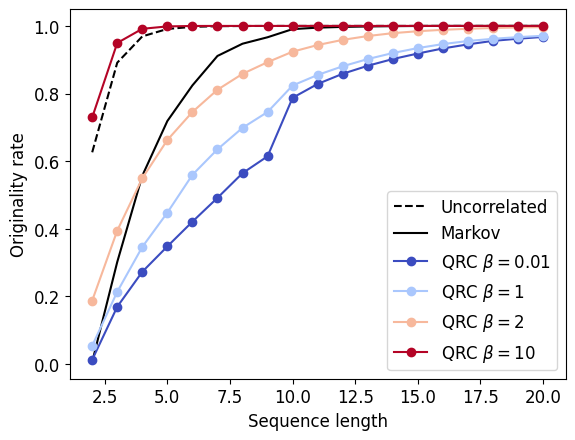

In [119]:
plt.plot(originality[0].keys(),originality[0].values(),'k--',label="Uncorrelated")
plt.plot(originality[1].keys(),originality[1].values(),'k',label="Markov")

cmap = plt.colormaps.get_cmap("coolwarm")
colors = [cmap(i) for i in np.linspace(0, 1, )] 

for i,b in enumerate([2,7,8,10]):
    beta = beta_list[b-2]
    color = cmap(i/3)
    plt.plot(originality[b].keys(),originality[b].values(),'o-',label="QRC $\\beta="+str(beta)+"$",color=color)

plt.legend()
plt.ylabel("Originality rate")
plt.xlabel("Sequence length")
plt.savefig("./Figures/originality.png",dpi=300)
plt.show()

as well as the rate of finding broken transitions

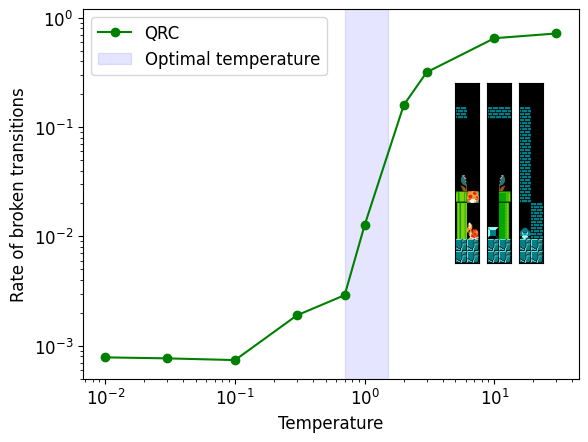

In [86]:
norm_mistake = np.array(mistakes,dtype=float)[:,1]

images =  [Image.open("./Figures/error2-"+str(i)+".png") for i in range(1,4)]
img_width, img_height = images[0].size
scale = 0.05


fig, ax1 = plt.subplots()
ax1.plot(beta_list,norm_mistake[2:,0],'o-',color="green",label="QRC")

for i,image in enumerate(images):
    inset = fig.add_axes([0.7 + i*scale, 0.35, scale,scale* img_height/img_width])
    inset.imshow(image)
    plt.setp(inset, xticks=[], yticks=[])

ax1.fill_betweenx(
    y=np.linspace(-1, 2, 100),  # Vertical range of the shaded region
    x1=0.7,  # Left boundary
    x2=1.5,  # Right boundary
    color="blue",
    alpha=0.1,  # Transparency
    label="Optimal temperature"
)
ax1.set_ylim((0.0005,1.2))
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("Rate of broken transitions")
ax1.set_xlabel("Temperature")
ax1.legend()
plt.savefig("./Figures/errors.png",dpi=300)

plt.show()

we can also see how repetitive the sequence is by checking the entropy (lower entropy means more repetitive)

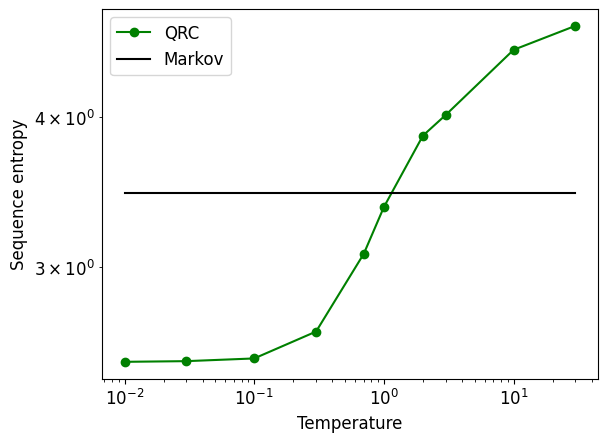

In [125]:
plt.plot(beta_list,repetiveness[2:],'o-',color="green",label="QRC")
plt.plot(beta_list,np.array(beta_list)*0 + repetiveness[1],'-',color="k",label="Markov")
#plt.plot(beta_list,beta_list*0 + repetiveness[0],'--',color="green")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Sequence entropy")
plt.xlabel("Temperature")
plt.legend()
plt.show()